Second goal: Generate a new training set of images of size `target_size` 

In [1]:
import csv 
import pandas as pd 
from PIL import Image, ImageDraw
import itertools
import operator
import random

In [2]:
target_size = [256, 256]

TODO: One problem is that we have to reject any bounding boxes whose size is > target_size

In [3]:
with open('training_data/images/deduped_annotations.csv') as f : 
    ls = list(csv.reader(f))[1:]
    
def to_annotation(l) : 
    # Note swap of 1st and 2nd Y
    return ("training_data/images/" + l[0][11:],int(l[1]),int(l[4]),int(l[3]),int(l[2]),1)

annotations = [to_annotation(l) for l in ls]

In [4]:
ls[0:3]

[['niihau/jpg/1_1920_04_07.jpg', '474', '667', '524', '617', 'P'],
 ['niihau/jpg/1_1920_06_12.jpg', '940', '393', '990', '343', 'B'],
 ['niihau/jpg/1_1920_07_13.jpg', '242', '529', '292', '479', 'P']]

In [5]:
annotations[0:3]

[('training_data/images/1_1920_04_07.jpg', 474, 617, 524, 667, 1),
 ('training_data/images/1_1920_06_12.jpg', 940, 343, 990, 393, 1),
 ('training_data/images/1_1920_07_13.jpg', 242, 479, 292, 529, 1)]

In [6]:
grouped = {}
uniquekeys = []
for k, g in itertools.groupby(sorted(annotations), operator.itemgetter(0)):
    grouped[k]=[item for item in g]
    uniquekeys.append(k)


In [7]:
grouped[uniquekeys[0]]

[('training_data/images/1_1006_30_28.jpg', 888, 657, 938, 707, 1)]

In [8]:
list(filter(lambda k : len(grouped[k]) > 4, uniquekeys))[0]

'training_data/images/1_1171_04_25.jpg'

grouped is now a `dict` from `fname` to `annotations list` where annotation is `x0, y0, x1, y1`

In [9]:
k = 'training_data/images/1_1171_04_25.jpg'
g = grouped[k]
g = [('training_data/images/1_1171_04_25.jpg', 211, 510, 261, 560, 1),
 ('training_data/images/1_1171_04_25.jpg', 253, 462, 303, 512, 1),
 ('training_data/images/1_1171_04_25.jpg', 278, 454, 308, 479, 1),
 ('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1),
 ('training_data/images/1_1171_04_25.jpg', 380, 600, 415, 640, 1)]
grouped[k] = g



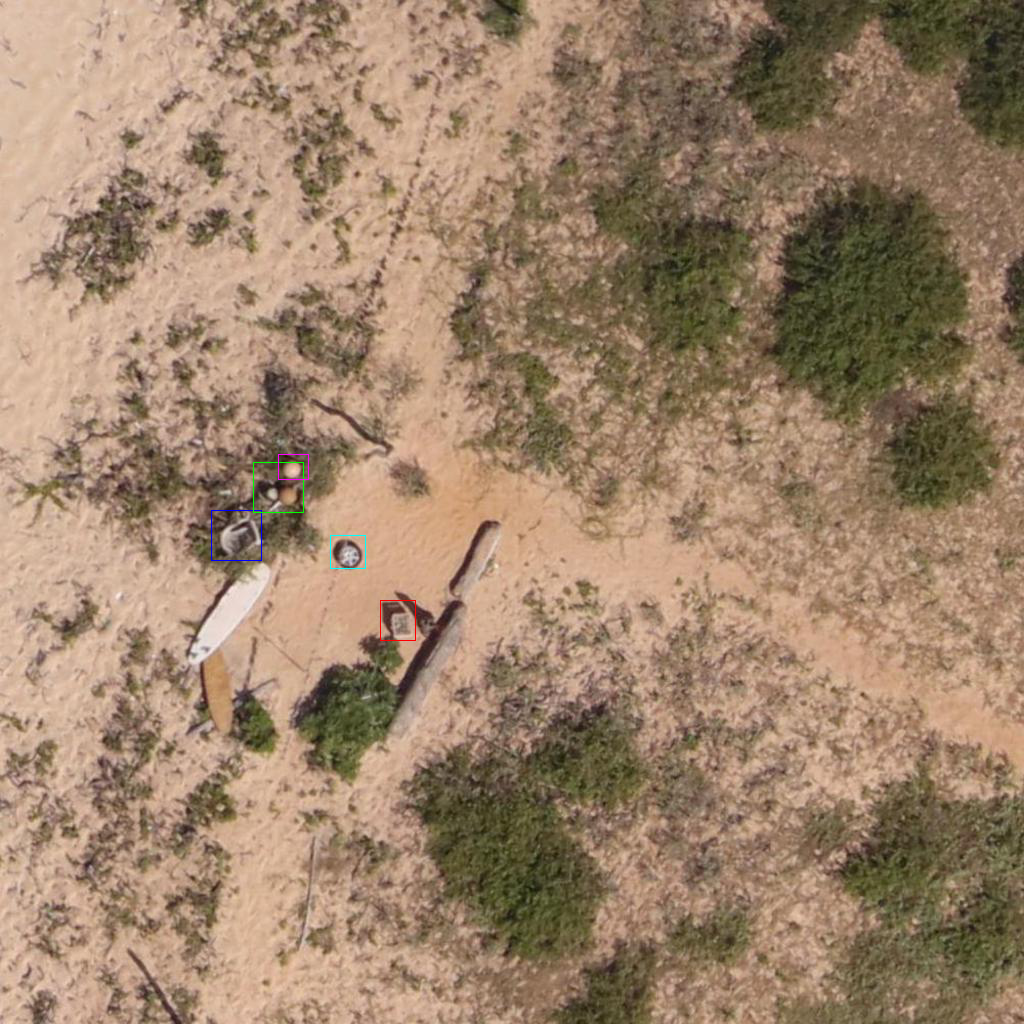

In [10]:
orig = Image.open(g[0][0])
dc = ImageDraw.Draw(orig)
dc.rectangle(g[0][1:5], outline=(0,0,255))
dc.rectangle(g[1][1:5], outline=(0,255,0))
dc.rectangle(g[2][1:5], outline=(255,0,255))
dc.rectangle(g[3][1:5], outline=(0, 255, 255))
dc.rectangle(g[4][1:5], outline=(255, 0, 0))
orig

In [11]:
annotation = g[3]
annotation

('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1)

In [12]:
# Just validates that this target BB can fit within the resized image
# If this is false, reject the BB
def is_valid_span(span_size, span_min, span_max) :
    return span_size > abs(span_max - span_min)

span_min = annotation[1]
span_max = annotation[3]
is_valid_span(256, span_min, span_max)

True

In [13]:
def span_start(span_size, image_max, start) : 
    if start + span_size > image_max : 
        return image_max - span_size
    else : 
        return start

In [14]:
def crop_loc(target_size, image_size, xStart, yStart) : 
    #print(f"crop_loc({target_size}, {xStart}, {yStart}")
    x = span_start(target_size[0], image_size[0], xStart)
    y = span_start(target_size[1], image_size[1], yStart)
    return (x, y)

crop_loc((1000,1000), (1024,1024),12,12)

(12, 12)

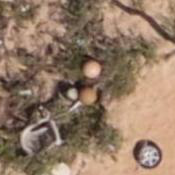

In [15]:
##### Returns cropped image and new bounding box
def cropped_image(srcImg, loc, sz) :
    #print(f"cropped_image(srcImg, {loc}, {sz})")
    return srcImg.crop([loc[0], loc[1], loc[0] + sz[0], loc[1] + sz[1]])
    #newImg = srcImg.copy()
    #dc = ImageDraw.Draw(newImg)
    #dc.rectangle([loc[0], loc[1], loc[0] + sz[0], loc[1] + sz[1]], outline = (255,0,0))
    #return newImg

def test(fname) :
    img = Image.open(fname)
    return cropped_image(img, [200,400], [175,175] )

test(annotation[0])

In [16]:
def scaled_bb (original_size, original_bb, crop_x, crop_y, target_size) :
    #print(f"scaled_bb({original_size}, {original_bb}, {crop_x}, {crop_y}, {target_size})")
    normalized_bb = [ original_bb[0] / original_size[0], original_bb[1] / original_size[1], original_bb[2] / original_size[0], original_bb[3] / original_size[1] ]
    normalized_crop = [crop_x / original_size[0], crop_y / original_size[1]]
    #print(f"normalized_bb {normalized_bb}")
    #print(f"normalized_crop {normalized_crop}")
    shifted_bb = [normalized_bb[0] - normalized_crop[0], normalized_bb[1] - normalized_crop[1], normalized_bb[2] - normalized_crop[0], normalized_bb[3] - normalized_crop[1]]
    #print(f"shifted_bb {shifted_bb}")
    scaled_bb = [shifted_bb[0] * original_size[0], shifted_bb[1] * original_size[1], shifted_bb[2] * original_size[0], shifted_bb[3] * original_size[1]]
    #print(f"scaled_bb {scaled_bb}")
    return scaled_bb

def testIdentity(annotation) :
    bb = annotation[1:5]
    original_size = [1024, 1024]
    crop_x = 0
    crop_y = 0
    target_size = [1024,1024]
    same = scaled_bb(original_size, bb, crop_x, crop_y, target_size)
    print(f"{same} = {bb}")

def testScale(annotation) :
    bb = annotation[1:5]
    original_size = [1024, 1024]
    crop_x = 0
    crop_y = 0
    target_size = [512,512]
    r = scaled_bb(original_size, bb, crop_x, crop_y, target_size)
    print(f"{bb} -> halfSize {r}")

def testShift(annotation) :
    bb = annotation[1:5]
    original_size = [1024, 1024]
    crop_x = 100
    crop_y = 50
    target_size = [1024,1024]
    r = scaled_bb(original_size, bb, crop_x, crop_y, target_size)
    print(f"{bb} -> shift {r}")    

def testSAndS() :
    bb = [200, 220, 230, 240]
    original_size = [1000, 1000]
    crop_x = 100
    crop_y = 100
    target_size = [100, 100]
    r = scaled_bb(original_size, bb, crop_x, crop_y, target_size)
    print(f"{bb} -> sAnds {r}")
    
def test(annotation) : 
    bb = annotation[1:5]
    original_size = [1024, 1024]
    crop_x = 233
    crop_y = 442
    target_size = [256,256]
    return scaled_bb(original_size, bb, 0, 0, original_size)

testIdentity(annotation)
testScale(annotation)
testShift(annotation)
testSAndS()

[330.0, 535.0, 365.0, 568.0] = (330, 535, 365, 568)
(330, 535, 365, 568) -> halfSize [330.0, 535.0, 365.0, 568.0]
(330, 535, 365, 568) -> shift [230.0, 485.0, 265.0, 518.0]
[200, 220, 230, 240] -> sAnds [100.0, 120.0, 130.0, 139.99999999999997]


In [17]:
def crop(target_size, src_bb, srcImg, xRandFn, yRandFn) :
    xStart = xRandFn(src_bb[0])
    yStart = yRandFn(src_bb[1])
    image_size = srcImg.size
    cropLoc = crop_loc(target_size, image_size, xStart, yStart)
    print(f"cropLoc -> {cropLoc}")
    cropSz = target_size
    ci = cropped_image(srcImg, cropLoc, cropSz)
    new_bb = scaled_bb(image_size, src_bb, xStart, yStart, target_size)
    return (ci, cropLoc, new_bb)

def test(annotation) : 
    srcImg = Image.open(annotation[0])
    target_size = [256,256]
    src_bb = annotation[1:5]
    xRandFn = lambda x : 0
    yRandFn = xRandFn
    return crop(target_size, src_bb, srcImg, xRandFn, yRandFn)

test(annotation)

cropLoc -> (0, 0)


(<PIL.Image.Image image mode=RGB size=256x256 at 0x1083DB550>,
 (0, 0),
 [330.0, 535.0, 365.0, 568.0])

annotation -> ('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1)
cropLoc -> (12, 12)
cropLoc -> (12, 12), bb -> [318.0, 523.0, 353.0, 556.0]


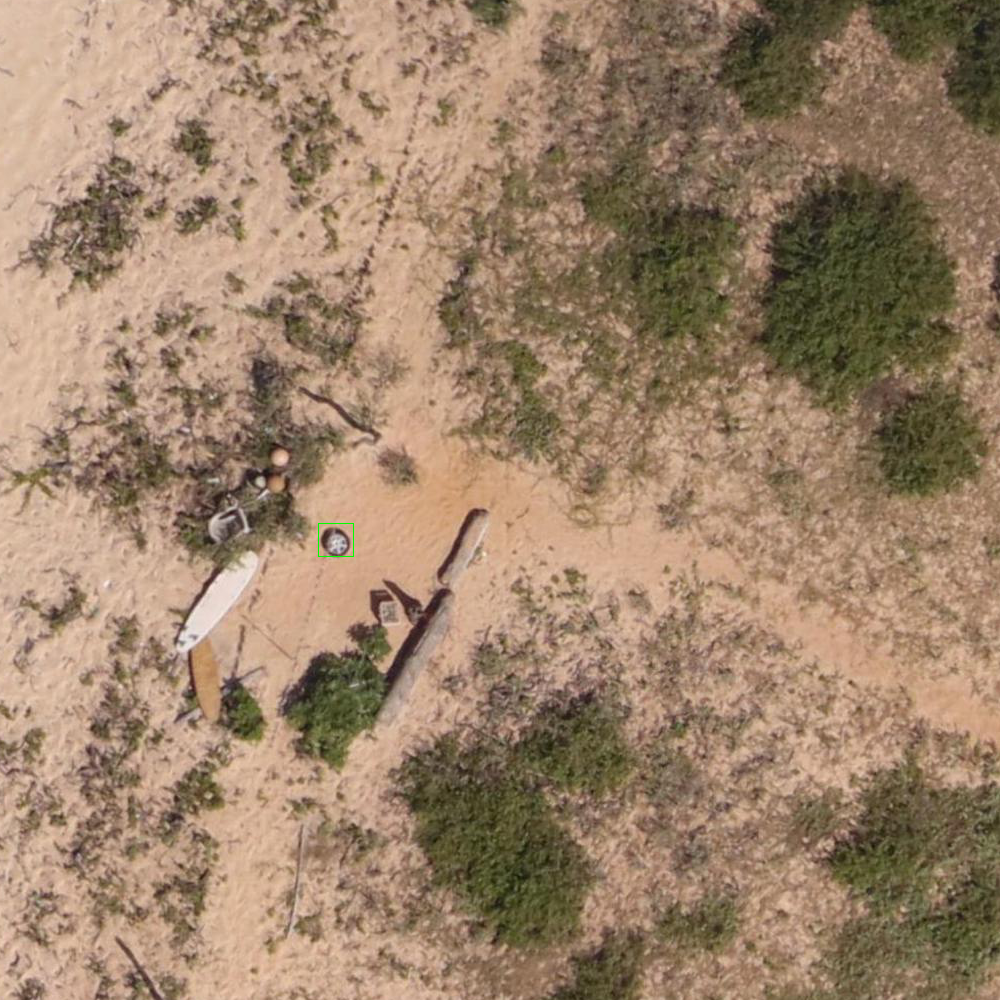

In [18]:
def tryIt (annotation, fn) :
    target_size = [1000,1000]
    target_bb = annotation[1:5]
    fname = annotation[0]
    img = Image.open(fname)
    return crop(target_size, target_bb, img, fn, fn)

def addBB(imgIn, r) : 
    #print(f"addBB(imgIn, {r})")
    img = imgIn.copy()
    draw = ImageDraw.Draw(img)
    draw.rectangle([r[0], r[1], r[2], r[3]], outline=(0,255,0))
    return img

print(f"annotation -> {annotation}")
(croppedImg, cropLoc, bb) = tryIt(annotation, lambda x : 12)
print(f"cropLoc -> {cropLoc}, bb -> {bb}")
addBB(croppedImg,bb)

cropLoc -> (24, 24)


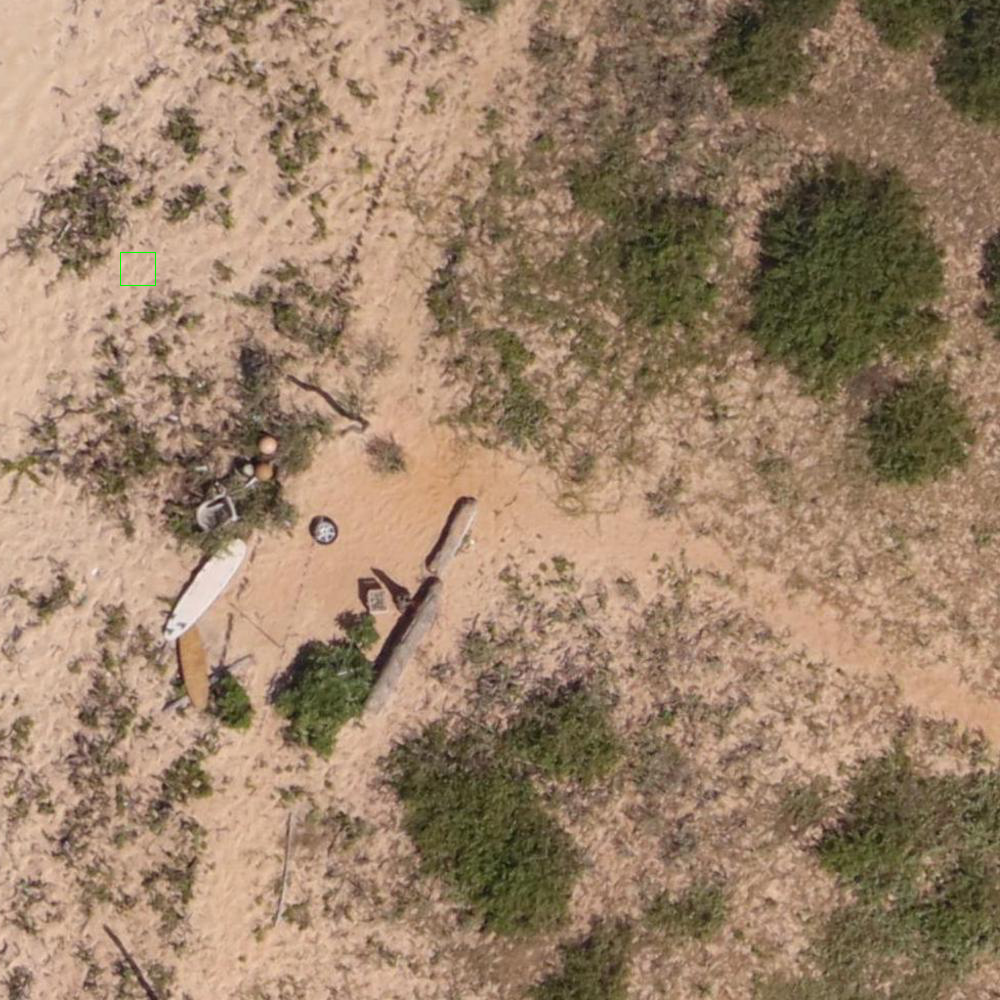

In [19]:
(croppedImg, cropLoc, bb) = tryIt(annotation, lambda x : random.randint(1,x))
addBB(croppedImg, bb)

NOW! In an example such as the above, I definitely need to add BBs for the _other_ targets in the frame!

In [20]:
anns = grouped[annotation[0]]
anns

[('training_data/images/1_1171_04_25.jpg', 211, 510, 261, 560, 1),
 ('training_data/images/1_1171_04_25.jpg', 253, 462, 303, 512, 1),
 ('training_data/images/1_1171_04_25.jpg', 278, 454, 308, 479, 1),
 ('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1),
 ('training_data/images/1_1171_04_25.jpg', 380, 600, 415, 640, 1)]

In [21]:
annotation

('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1)

In [22]:
orig_img_size = [1024,1024]
ss = list(map(lambda r : [r[0] / orig_img_size[0], r[1] / orig_img_size[1], r[2] / orig_img_size[0], r[3] / orig_img_size[1]], (map(lambda t : [t[0], t[1], t[2], t[3]], (map(lambda a : a[1:5], anns))))))

In [23]:
ss

[[0.2060546875, 0.498046875, 0.2548828125, 0.546875],
 [0.2470703125, 0.451171875, 0.2958984375, 0.5],
 [0.271484375, 0.443359375, 0.30078125, 0.4677734375],
 [0.322265625, 0.5224609375, 0.3564453125, 0.5546875],
 [0.37109375, 0.5859375, 0.4052734375, 0.625]]

In [24]:
def crop_pt_normalized(crop_loc, orig_img_size) :
    return [crop_loc[0] / orig_img_size[0], crop_loc[1] / orig_img_size[1]]

In [25]:
def shifted_normalized(a, cp) : 
    a0 = max(0, a[0] - cp[0])
    a1 = max(0, a[1] - cp[1])
    a2 = min(1, a[2] - cp[0])
    a3 = min(1, a[3] - cp[1])
    if a2 < 0 or a3 < 0 or a0 > 1 or a1 > 1:
        return None
    
    return [a0, a1, a2, a3]

sns = [some for some in [shifted_normalized(s, [0.23,0]) for s in ss] if some]
sns

[[0, 0.498046875, 0.02488281249999999, 0.546875],
 [0.01707031249999999, 0.451171875, 0.06589843749999999, 0.5],
 [0.04148437499999999, 0.443359375, 0.07078124999999999, 0.4677734375],
 [0.09226562499999999, 0.5224609375, 0.1264453125, 0.5546875],
 [0.14109375, 0.5859375, 0.1752734375, 0.625]]

In [26]:
def normalized_bbs(crop_loc, orig_img_size, annotation, grouped) : 
    anns = grouped[annotation[0]].copy()
    #anns.remove(annotation)
    a0 = [a[1:5] for a in anns]
    a1 = [tuple(a) for a in a0]
    a2 = [[r[0] / orig_img_size[0], r[1] / orig_img_size[1], r[2] / orig_img_size[0], r[3] / orig_img_size[1]] for r in a1]
    cpn = crop_pt_normalized(crop_loc, orig_img_size)
    a3 = [some for some in [shifted_normalized(a, cpn) for a in a2] if some]
    return a3

ann = g[0]
normalized_bbs((85,60), (1024,1024), ann, grouped)

[[0.123046875, 0.439453125, 0.171875, 0.48828125],
 [0.1640625, 0.392578125, 0.212890625, 0.44140625],
 [0.1884765625, 0.384765625, 0.2177734375, 0.4091796875],
 [0.2392578125, 0.4638671875, 0.2734375, 0.49609375],
 [0.2880859375, 0.52734375, 0.322265625, 0.56640625]]

In [27]:
def add_normalized_bb(imgIn, nbb) :
    img = imgIn.copy()
    draw = ImageDraw.Draw(img)
    imgSize = img.size
    x0 = nbb[0] * imgSize[0]
    x1 = nbb[2] * imgSize[0]
    y0 = nbb[1] * imgSize[1]
    y1 = nbb[3] * imgSize[1]
    r = [x0, y0, x1, y1]
    draw.rectangle(r, outline=(0,255,0))
    return img

cropLoc -> (0, 0)


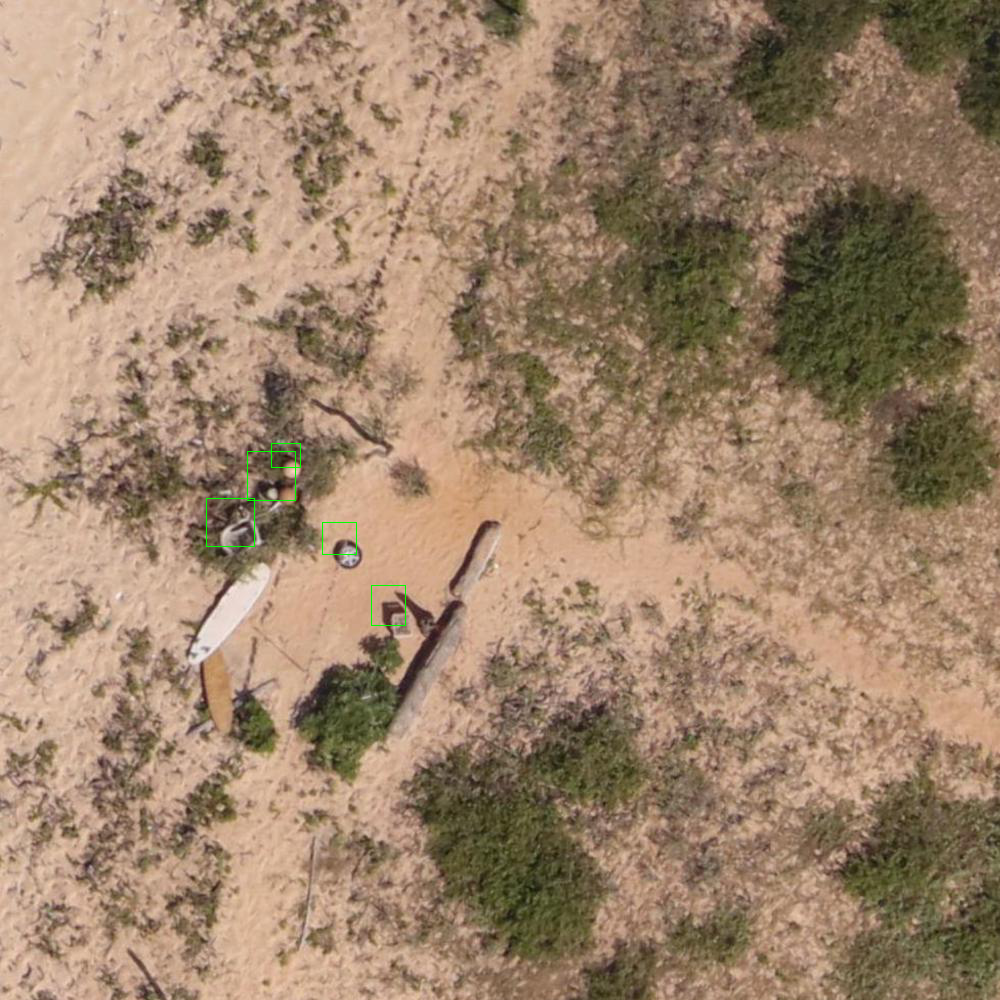

In [28]:
target_size = [1000,1000]
target_bb = ann[1:5]
fname = ann[0]
img = Image.open(fname)
fn = lambda x : 0
(ci, cropLoc, new_bb) = crop(target_size, target_bb, img, fn, fn)
nbbs = normalized_bbs(cropLoc, img.size, ann, grouped) 
for nbb in nbbs : 
    ci = add_normalized_bb(ci, nbb)
ci

target_bb -> (211, 510, 261, 560)
cropLoc -> (24, 24)
cropLoc -> (24, 24)
bb -> [0.1826171875, 0.474609375, 0.2314453125, 0.5234375]
bb -> [0.2236328125, 0.427734375, 0.2724609375, 0.4765625]
bb -> [0.248046875, 0.419921875, 0.27734375, 0.4443359375]
bb -> [0.298828125, 0.4990234375, 0.3330078125, 0.53125]
bb -> [0.34765625, 0.5625, 0.3818359375, 0.6015625]


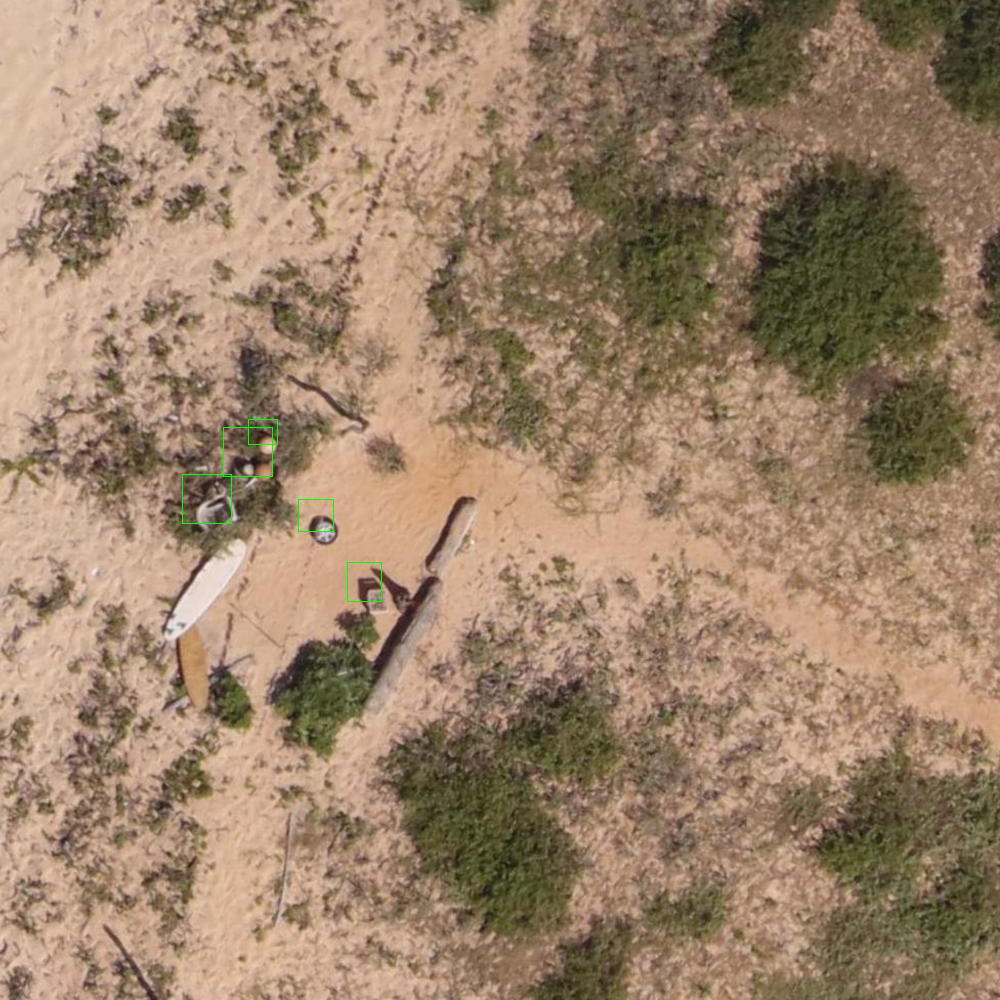

In [29]:
target_size = [1000,1000]
target_bb = ann[1:5]
print(f"target_bb -> {target_bb}")
fname = ann[0]
img = Image.open(fname)
fn = lambda x : 512 
(ci, cropLoc, new_bb) = crop(target_size, target_bb, img, fn, fn)
print(f"cropLoc -> {cropLoc}")
nbbs = normalized_bbs(cropLoc, img.size, ann, grouped) 
for nbb in nbbs : 
    print(f"bb -> {nbb}")
    ci = add_normalized_bb(ci, nbb)
ci

cropLoc -> (191, 490)


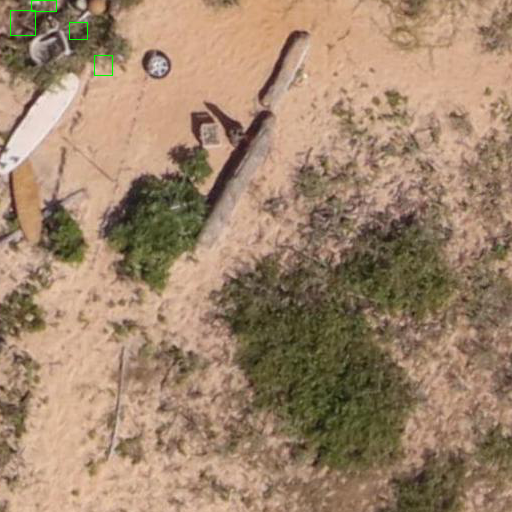

In [30]:
target_size = [512,512]
target_bb = ann[1:5]
fname = ann[0]
img = Image.open(fname)
fn = lambda x : x - 20
(ci, cropLoc, new_bb) = crop(target_size, target_bb, img, fn, fn)
nbbs = normalized_bbs(cropLoc, img.size, ann, grouped) 
for nbb in nbbs : 
    ci = add_normalized_bb(ci, nbb)
ci

cropLoc -> (9, 177)


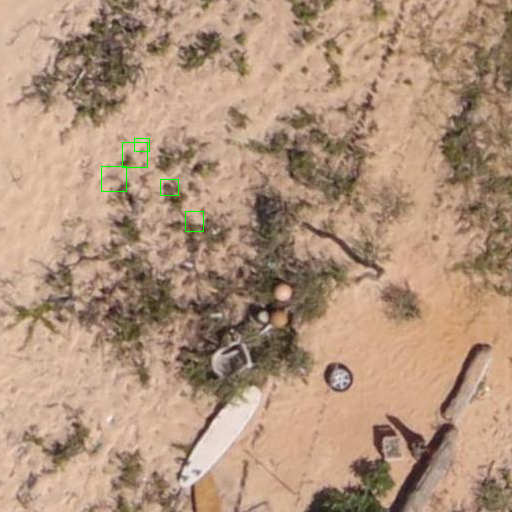

In [31]:
target_size = [512,512]
target_bb = ann[1:5]
fname = ann[0]
img = Image.open(fname)
fn = lambda x : random.randint(0,x - 5)
(ci, cropLoc, new_bb) = crop(target_size, target_bb, img, fn, fn)
nbbs = normalized_bbs(cropLoc, img.size, ann, grouped) 
for nbb in nbbs : 
    ci = add_normalized_bb(ci, nbb)
ci

In [32]:
nbbs

[[0.197265625, 0.3251953125, 0.24609375, 0.3740234375],
 [0.23828125, 0.2783203125, 0.287109375, 0.3271484375],
 [0.2626953125, 0.2705078125, 0.2919921875, 0.294921875],
 [0.3134765625, 0.349609375, 0.34765625, 0.3818359375],
 [0.3623046875, 0.4130859375, 0.396484375, 0.4521484375]]

Looks like I've screwed up. You can see in that one that the nbbs are all pretty much in the top half, but all the targets are near the bottom. So what's the deal with that? 

I think I should rework the whole damn thing based on normalizing the annotations ASAP.

Something I've noticed with this Notebook is that with Python, which is kind of function-first, you deal with these components (functions) that have a rather "lego"-like feel. You do something, it's not quite right, you pull it apart or add a function or what-have-you. While, if you commit to an Object, you have a certain metaphor to which you commit for some period of time. On the one hand, if it's the right metaphor it keeps you "on the track", on the other, if it's the wrong metaphor, it's harder to pull apart. So which is the route towards 10X? 

In [34]:
a = Annotation('Larry')
a.say_hi()

Hello, my name is Larry
